# Joint project AMD - SM2L
Davide Gavio - 930569





# Google Colab settings
Those actions need to be done in order to have the notebook working on Google Colab. 
If the notebook is executed elsewhere skip to the next cell.


In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz   
!tar xf spark-3.0.1-bin-hadoop2.7.tgz
!pip install -q findspark pyspark seaborn kaggle scikit-learn matplotlib pandas
!rm spark-3.0.1-bin-hadoop2.7.tgz
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"

     |████████████████████████████████| 204.2MB 74kB/s 
     |████████████████████████████████| 204kB 43.6MB/s 


# PySpark settings


In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
max_memory = '4g'
spark = SparkSession.builder.appName('amd-sm2l-project').master("local[*]").config("spark.executor.memory", max_memory).config("spark.driver.memory", max_memory).getOrCreate()

# Imports and settings


In [ ]:
!mkdir ~/.kaggle
!echo '{"username":"davidegavio","key":"f4540434f20370f2bf34e2f9010b647e"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
from matplotlib.pyplot import xlabel, ylabel
import pandas as pd
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
import pyspark.sql.functions as f
from pyspark.sql.types import DoubleType, Row
from pyspark.context import SparkContext
from pyspark.ml import Pipeline
from pyspark.ml.feature import Imputer, MinMaxScaler, OneHotEncoder, VectorAssembler, StringIndexer, StandardScaler
from pyspark.mllib.linalg import DenseVector
from pyspark.mllib.regression import LabeledPoint, RidgeRegressionWithSGD
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import ChiSqSelector, VectorIndexer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from zipfile import ZipFile
import os
from datetime import datetime
from pyspark.sql.types import *
import math
import kaggle

In [ ]:
learning_rate = 0.000000001
n_iterations = 1
folds = 10
lowest_error = float('inf')
alphas = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]
num_partitions = spark.sparkContext.defaultParallelism * 3

In [ ]:
print('Parallelism info')
print("Default parallelism: {}".format(spark.sparkContext.defaultParallelism))
print("Custom parallelism: {}\n".format(num_partitions))

Parallelism info
Default parallelism: 2
Custom parallelism: 6



# Ridge Regression


In [ ]:
import numpy as np 
import math
from datetime import datetime
from pyspark.sql import SparkSession
from progressbar import ProgressBar
 
 
 
class SparkRidgeRegression(object):
    """ Base regression model. Models the relationship between a scalar dependent variable y and the independent 
        variables X. 
        Parameters:
        -----------
        n_iterations: float
            The number of training iterations the algorithm will tune the weights for.
        learning_rate: float
            The step length that will be used when updating the weights."""
    def __init__(self, n_iterations, learning_rate, reg_factor):
        self.n_iterations = n_iterations
        self.learning_rate = learning_rate
        self.reg_factor = reg_factor
    
    def get_training_errors(self):
        return self.training_errors
    
    def set_training_errors(self, error):
        self.training_errors = error
 
    def squared_error(self, target, prediction):
        return (target - prediction) ** 2
 
    def root_mean_squared_error(self, predictions):
        return np.sqrt(predictions.map(lambda p: self.squared_error(*p)).mean())
 
    def mean_squared_error(self, predictions):
        return predictions.map(lambda p: self.squared_error(p[0], p[1])).mean()
 
    def mean_absolute_error(self, predictions):
        return np.abs(predictions.map(lambda prediction: prediction[1] - prediction[0]).reduce(lambda a, b: a + b))/predictions.count()
    
    def r2(self, predictions):
        mean_ = predictions.rdd.map(lambda t: t[0]).mean()
        sum_squares = predictions.rdd.map(lambda t: (t[0] - mean_)**2).sum()
        residual_sum_squares = predictions.rdd.map(lambda t: self.squared_error(*t)).sum()
        return 1 - (residual_sum_squares / sum_squares)
 
 
    def get_grad_sum(self, example):
        return (self.weights.dot(DenseVector(example.features)) - example.label) * example.features
 
    
    def fit(self, observations):
        progressbar = ProgressBar()
        features_number = len(observations.take(1)[0].features)
        self.training_errors = []
        self.weights = np.zeros(features_number)        
        start = datetime.now()
        # Do gradient descent for n_iterations
        for i in progressbar(range(self.n_iterations)):
          # Get the prediction given an example and the current weights
          predictions = observations.map(lambda example: self.predict(example)) # Result [label, prediction]
          # Calculate l2 loss
          regularization = self.reg_factor * self.weights
          self.training_errors.append(self.root_mean_squared_error(predictions))
          # Gradient of l2 loss w.r.t w
          grad_w = observations.map(lambda example: DenseVector(self.get_grad_sum(example))).reduce(lambda x, y: x + y) + regularization
          # Update the weights
          self.weights -= self.learning_rate * grad_w
          if i == self.n_iterations-1:
            float_predictions = predictions.map(lambda xs: [float(x) for x in xs])
            predictions_df = float_predictions.toDF(['label', 'predictions'])
            print('From scratch training MSE: {}'.format(self.mean_squared_error(predictions=predictions)))
            print('From scratch training RMSE: {}'.format(self.root_mean_squared_error(predictions=predictions)))
            print('From scratch training MAE: {}'.format(self.mean_absolute_error(predictions=predictions)))
            print('From scratch test R2: {}'.format(self.r2(predictions_df))
 
    def predict(self, example):
        return (example.label, self.weights.dot(DenseVector(example.features)))

# Utilities

In [ ]:
def to_labeledpoint(row):
  row_dict = row.asDict()
  target = np.array(row_dict['target'][0])
  features = np.array(row_dict['scaled_features']).tolist()
  features.insert(0, 1.0)
  return LabeledPoint(target, features)

def remove_outliers(df):
  quantiles = df.approxQuantile(label_to_predict, [0.25, 0.75], 0.1)
  iqr = quantiles[1] - quantiles[0]
  if iqr != 0:
    df = df.filter(f.col(label_to_predict).between(quantiles[0] - (1.5 * iqr), quantiles[1] + (1.5 * iqr)))
  return df

# Dataset download

In [ ]:
print('Downloading necessary files from Kaggle')
startTime = datetime.now()
kaggle.api.authenticate()
if os.path.exists('ss13pusa.csv'):
  os.remove('ss13pusa.csv')
elif os.path.exists('ss13pusb.csv'):
  os.remove('ss13pusb.csv')
else:
  print('The file does not exist')
kaggle.api.dataset_download_file('census/2013-american-community-survey ', 'ss13pusa.csv')
kaggle.api.dataset_download_file('census/2013-american-community-survey ', 'ss13pusb.csv')
with ZipFile('ss13pusa.csv.zip', 'r') as zipObj:
   zipObj.extractall()
with ZipFile('ss13pusb.csv.zip', 'r') as zipObj:
   zipObj.extractall()
os.remove('ss13pusa.csv.zip')
os.remove('ss13pusb.csv.zip')
print('Your download has been completed in: {}'.format(datetime.now() - startTime))

The file does not exist
Your download has been completed in: 0:00:41.322735


# Preprocessing

In [ ]:
%%time
print('Reading from csv')
df_a = spark.read.csv('ss13pusa.csv', inferSchema=True, header=True)
df_a = df_a.sample(False, 0.075, 6)
df_b = spark.read.csv('ss13pusb.csv', inferSchema=True, header=True)
df_b = df_b.sample(False, 0.075, 6)
df = df_a.union(df_b)
df = df.repartition(numPartitions=num_partitions)
label_to_predict = 'WAGP'
drop_thresh = .66
print(f"The shape is {df.count():d} rows by {len(df.columns):d} columns.")
print('The dataframe is divided in {} partitions'.format(df.rdd.getNumPartitions()))
print('==> Done\n')

Reading from csv
The shape is 235486 rows by 283 columns.
The dataframe is divided in 6 partitions
==> Done

CPU times: user 102 ms, sys: 29.5 ms, total: 131 ms
Wall time: 1min 23s


In [ ]:
df.select(label_to_predict).describe().show()

+-------+------------------+
|summary|              WAGP|
+-------+------------------+
|  count|             16681|
|   mean|20308.095917510942|
| stddev|36305.089577609935|
|    min|                 0|
|    max|            327000|
+-------+------------------+



In [ ]:
%%time
print('Dropping useless columns, columns and rows with more than {}% of null values'.format(drop_thresh*100))
df = df.select(*(f.col(c).cast("float").alias(c) for c in df.columns)) # Casting the dataframe to float
df = df.drop('RT', 'SERIALNO', 'PINCP ', 'PERNP' ) # Removing unnecessary columns
count_before = df.count()
thresh = int(len(df.columns)*drop_thresh)
df = df.dropna(thresh=thresh) # Dropping rows with more than 66% of null values
print('Dropped {} rows with less than {}% of non-null values'.format(count_before-df.count(), drop_thresh*100))
print('Keeping only rows with non-null value in target position')
count_before = df.count()
df = df.filter(df[label_to_predict].isNotNull()) # Keeping only the rows with not-null values in the corresponding label
data_agg = df.agg(*[f.count(f.when(f.isnull(c), c)).alias(c) for c in df.columns])
print('Dropped {} rows with with null in {} column'.format(count_before-df.count(), label_to_predict))
count_before = df.count()
col_before = len(df.columns)
over_thresh_col = df.select([(f.count(f.when(f.col(c).isNull(), c))/count_before).alias(c) for c in df.columns])
scheme = df.columns
null_distr = over_thresh_col.collect()[0].asDict().values()
for i in np.where(np.array(list(null_distr)) > ((1 - drop_thresh)))[0]:
  df = df.drop(scheme[i])
print('Dropped {} columns with less than {}% of non-null values'.format(col_before-len(df.columns), drop_thresh*100))
# print(f"The shape is {df.count():d} rows by {len(df.columns):d} columns.")
print('==> Done\n')

Dropping useless columns, columns and rows with more than 66.0% of null values
Dropped 0 rows with less than 66.0% of non-null values
Keeping only rows with non-null value in target position
Dropped 3319 rows with with null in WAGP column
Dropped 47 columns with less than 66.0% of non-null values
==> Done

CPU times: user 1.24 s, sys: 369 ms, total: 1.61 s
Wall time: 51.9 s


In [ ]:
df.select(label_to_predict).describe().show()

+-------+------------------+
|summary|              WAGP|
+-------+------------------+
|  count|             16681|
|   mean|20308.095917510942|
| stddev| 36305.08957760993|
|    min|               0.0|
|    max|          327000.0|
+-------+------------------+



In [ ]:
%%time
print('Removing outliers')
df = remove_outliers(df)

Removing outliers
CPU times: user 15.8 ms, sys: 5.28 ms, total: 21.1 ms
Wall time: 8.15 s


In [ ]:
%%time
imput_strategy = 'mean'
print('Filling remaining null values with {} of each column'.format(imput_strategy))
imputer = Imputer() # Filling missing values with mean of the column
imputer.setInputCols(df.columns)
imputer.setOutputCols(df.columns)
imputer.setStrategy(imput_strategy)
df = imputer.fit(df).transform(df)
print('==> Done\n')

Filling remaining null values with mean of each column
==> Done

CPU times: user 144 ms, sys: 27.7 ms, total: 172 ms
Wall time: 18.3 s


In [ ]:
df.select(label_to_predict).describe().show()

+-------+------------------+
|summary|              WAGP|
+-------+------------------+
|  count|             14694|
|   mean|10576.517490132026|
| stddev|14920.473500290755|
|    min|               0.0|
|    max|           50000.0|
+-------+------------------+



In [ ]:
%%time
print('Choosing top features, assembling and scaling values')
feature_columns = df.columns
feature_columns.remove(label_to_predict)
features_assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
feature_selector = ChiSqSelector(numTopFeatures=50, featuresCol="features", outputCol="selected_features", labelCol=label_to_predict)
target_assembler = VectorAssembler(inputCols=[label_to_predict], outputCol='target')
features_standardscaler = StandardScaler(inputCol='selected_features', outputCol='scaled_features', withStd=True, withMean=False)
df = Pipeline(stages=[features_assembler, target_assembler, feature_selector, features_standardscaler]).fit(df).transform(df)
print(f"The shape is {df.count():d} rows by {len(np.array(list(df.select('selected_features').take(1)))[0][0]):d} columns.")
print('==> Done\n')

Choosing top features, assembling and scaling values
The shape is 14694 rows by 50 columns.
==> Done

CPU times: user 207 ms, sys: 47.8 ms, total: 255 ms
Wall time: 1min 1s


In [ ]:
%%time
print('Creating labeled points')
to_label_df = df.select('target', 'scaled_features')
labeled_data = to_label_df.rdd.map(lambda row: to_labeledpoint(row))
print('Splitting in training set, validation set and test set')
labeled_train_df, labeled_validation_df, labeled_test_df = labeled_data.randomSplit(weights=[.6, .2, .2], seed=6)
labeled_train_df = labeled_train_df.repartition(num_partitions)
labeled_validation_df = labeled_validation_df.repartition(num_partitions)
labeled_test_df = labeled_test_df.repartition(num_partitions)
labeled_train_df.cache()
print('Training set count: {} divided in {} partitions'.format(labeled_train_df.count(), labeled_train_df.getNumPartitions()))
print('Validation set count: {} divided in {} partitions'.format(labeled_validation_df.count(), labeled_validation_df.getNumPartitions()))
print('Test set count: {} divided in {} partitions'.format(labeled_test_df.count(), labeled_test_df.getNumPartitions()))
print('==> Done\n')

Creating labeled points
Splitting in training set, validation set and test set
Training set count: 8818 divided in 6 partitions
Validation set count: 2880 divided in 6 partitions
Test set count: 2996 divided in 6 partitions
==> Done

CPU times: user 122 ms, sys: 35 ms, total: 157 ms
Wall time: 48.7 s


In [ ]:
print('Training and predictions will work on ')
labeled_data.take(2)

Training and predictions will work on 


[LabeledPoint(0.0, [1.0,0.34582504254644,2.0388785030870715,0.6373384271360183,6.751824614364044,5.701892665863204,11.628740622923033,4.000643104019263,4.347014318906432,5.7394680277083605,57.17618161897666,0.5814417183426508,19.433144598490614,16.09474499635029,3.6184165258154892,21.314288712381238,5.793577827681648,5.76754745853454,5.013941319897357,3.3131492535317837,2.2319917404073086,2.1848841201506577,3.264628013680964,2.1478770774955165,2.8718133691969716,2.3542006146647982,2.4948341708065276,5.621060191091287,0.9149332360065636,2.868809036262363,0.9310660918106292,4.52990876500679,0.048412095584263314,0.2793129848284936,1.7902275014134885,4.180619273513982,4.085809399751916,0.09909209157905884,0.2675741892179022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
 LabeledPoint(0.0, [1.0,0.138330017018576,2.5243257657268505,1.3591773369834004,3.375912307182022,2.850946332931602,11.628740622923033,4.000643104019263,4.347014318906432,2.8697340138541803,57.17618161897666,2.907208591

# Best model individuation

In [ ]:
%%time
from progressbar import ProgressBar
progressbar = ProgressBar()
print('Finding regularization factor using grid search')
best_reg_factor = 0
mean_squared_errors = []
for candidate_reg_factor in progressbar(alphas):
  print('Trying using {} as regularization factor'.format(candidate_reg_factor))
  mean_squared_error = 0
  candidate_rr = SparkRidgeRegression(n_iterations=n_iterations, learning_rate=learning_rate, reg_factor=candidate_reg_factor)
  candidate_rr.fit(labeled_train_df)
  print('Validating')
  candidate_pred = labeled_validation_df.map(lambda prediction: candidate_rr.predict(prediction))
  mean_squared_error = candidate_rr.mean_squared_error(predictions=candidate_pred)
  mean_squared_errors.append(mean_squared_error)
  if mean_squared_error < lowest_error:
    print('Currently best regularization factor: {}'.format(candidate_reg_factor))
    best_reg_factor = candidate_reg_factor
    lowest_error = mean_squared_error
print('Grid search terminated, chosen regularization factor: {}'.format(best_reg_factor))

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


MSE with different regularization factors


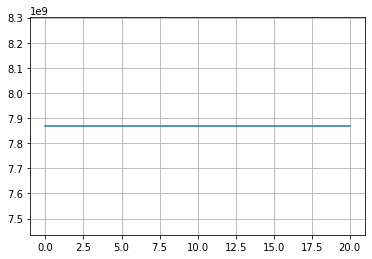

In [ ]:
print('MSE with different regularization factors')
sn.lineplot(alphas, mean_squared_errors).grid()

# Training and evaluation

In [ ]:
%%time
print('Training with {} as learning rate and {} as regularization factor'.format(learning_rate, 0.1))
spark_rr = SparkRidgeRegression(n_iterations=6000, learning_rate=0.00000003, reg_factor=0.01)
now = datetime.now()
spark_rr.fit(labeled_train_df)
print('==> Done in {}\n'.format(datetime.now()-now))

N/A% (0 of 6000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Training with 1e-09 as learning rate and 0.1 as regularization factor


100% (6000 of 6000) |####################| Elapsed Time: 1:23:47 Time:  1:23:47


==> Done in 1:23:47.564787

CPU times: user 14min 35s, sys: 26.9 s, total: 15min 2s
Wall time: 1h 23min 47s


In [ ]:
%%time
print('Predicting')
predictions = labeled_test_df.map(lambda prediction: spark_rr.predict(prediction))
float_predictions = predictions.map(lambda xs: [float(x) for x in xs])
predictions_df = float_predictions.toDF(['label', 'predictions'])
print('==> Done\n')

Predicting
==> Done

CPU times: user 249 ms, sys: 5.94 ms, total: 255 ms
Wall time: 304 ms


In [ ]:
%%time
root_mean_squared_error = spark_rr.root_mean_squared_error(predictions=predictions)
mean_squared_error = spark_rr.mean_squared_error(predictions=predictions)
mean_absolute_error = spark_rr.mean_absolute_error(predictions=predictions)
r2_score = spark_rr.r2(predictions_df)
print('From scratch test MSE: {}'.format(mean_squared_error))
print('From scratch test RMSE: {}'.format(root_mean_squared_error))
print('From scratch test MAE: {}'.format(mean_absolute_error))
print('From scratch test R2: {}'.format(r2_score))
print('==> Done\n')

From scratch test MSE: 88840739.55979964
From scratch test RMSE: 9425.53656614835
From scratch test MAE: 141.08021747711598
From scratch test R2: 0.6115190643846994
==> Done

CPU times: user 623 ms, sys: 10.4 ms, total: 633 ms
Wall time: 3.06 s


Text(0, 0.5, 'Training error')

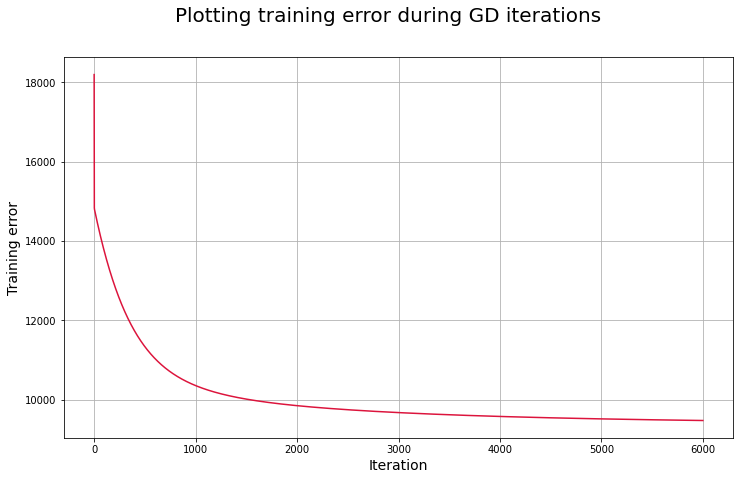

In [ ]:
fig = plt.figure(figsize = (12, 7))
g = sn.lineplot(x = np.arange(spark_rr.n_iterations), y = spark_rr.training_errors, color = 'crimson').grid()
fig.suptitle('Plotting training error during GD iterations', fontsize = 20)
plt.xlabel('Iteration', fontsize = 14)
plt.ylabel('Training error', fontsize = 14)